In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [5]:
# Drop customerID
df.drop("customerID", axis=1, inplace=True)

# Convert 'TotalCharges' to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')
df.dropna(inplace=True)

# 🛠️ 4. Feature Engineering
# Convert categorical columns

In [6]:
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
cat_cols.remove("Churn")

for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Encode target
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# Normalize numeric features
scaler = StandardScaler()
df[["tenure", "MonthlyCharges", "TotalCharges"]] = scaler.fit_transform(df[["tenure", "MonthlyCharges", "TotalCharges"]])



In [7]:
# 🎯 5. Prepare Train/Test Data
X = df.drop("Churn", axis=1)
y = df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# 🤖 6. Model Training
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 Model: {name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    y_probs = model.predict_proba(X_test)[:, 1]
    print("ROC-AUC Score:", roc_auc_score(y_test, y_probs))


📊 Model: Logistic Regression
[[921 112]
 [189 185]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.77      0.79      0.78      1407

ROC-AUC Score: 0.8307354623623628

📊 Model: Random Forest
[[932 101]
 [192 182]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407

ROC-AUC Score: 0.8128743444927033

📊 Model: XGBoost
[[893 140]
 [192 182]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1033
           1       0.57     

In [9]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC-AUC Score: {roc_auc:.2f}")

Confusion Matrix:
 [[893 140]
 [192 182]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      1033
           1       0.57      0.49      0.52       374

    accuracy                           0.76      1407
   macro avg       0.69      0.68      0.68      1407
weighted avg       0.75      0.76      0.76      1407

ROC-AUC Score: 0.81


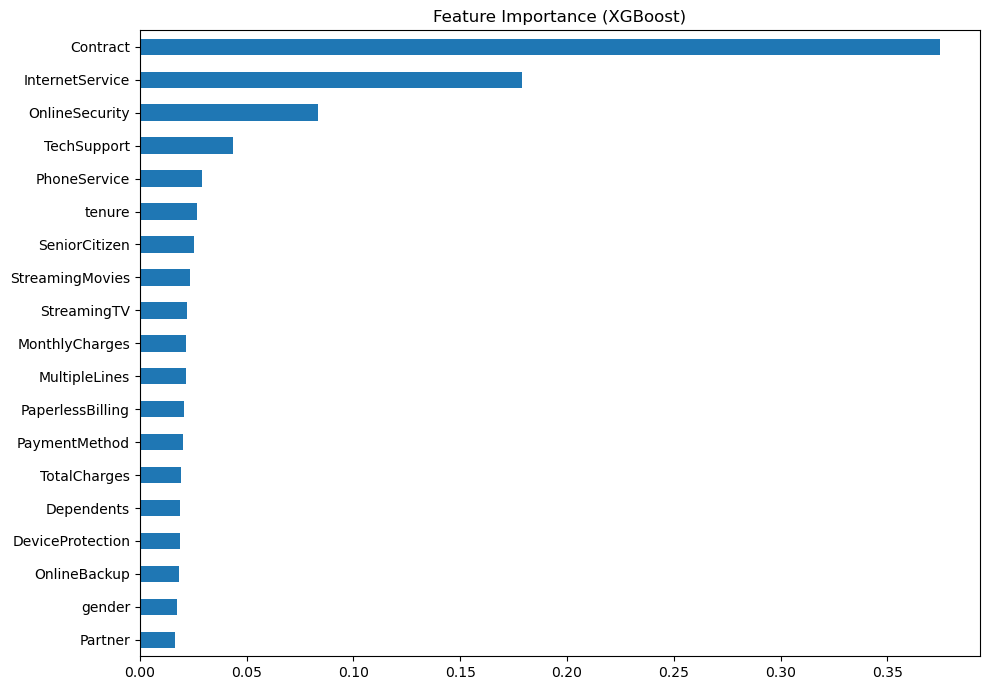

In [10]:
# 🌟 7. Feature Importance (XGBoost)
xgb_model = models["XGBoost"]
importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh", figsize=(10, 7), title="Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()

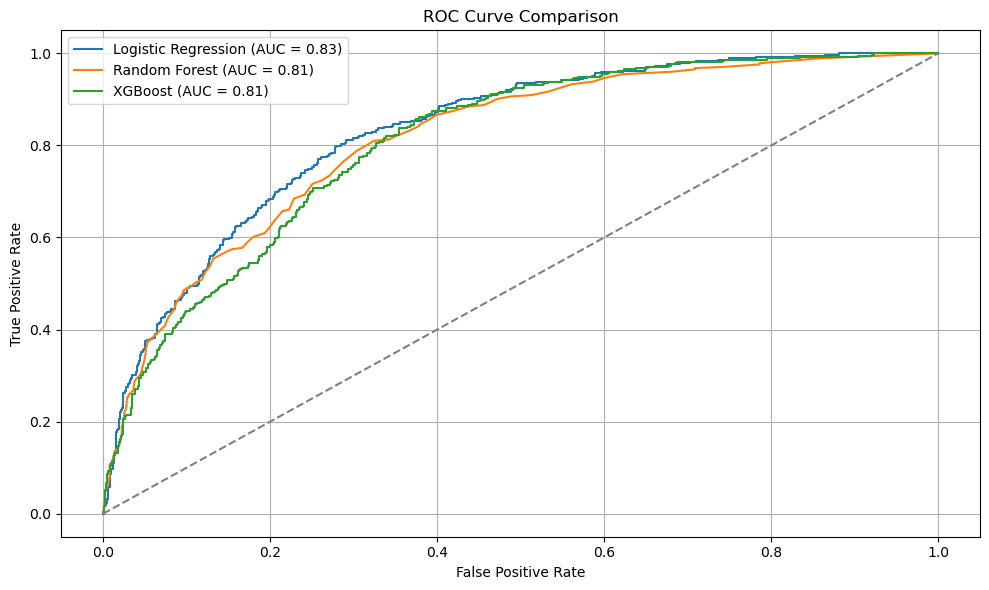

In [11]:
# 📉 8. ROC Curve for All Models
plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_probs):.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# 📄 9. Export Results
df_test = X_test.copy()
df_test["Actual Churn"] = y_test.values
df_test["Predicted Churn (XGBoost)"] = xgb_model.predict(X_test)
df_test["Churn Probability"] = xgb_model.predict_proba(X_test)[:, 1]
df_test.to_csv("churn_predictions.csv", index=False)
print("✅ Churn predictions exported to churn_predictions.csv")

✅ Churn predictions exported to churn_predictions.csv


In [16]:
!pip install fpdf


Defaulting to user installation because normal site-packages is not writeable


In [18]:
# Export CSV
from fpdf import FPDF
results = X_test.copy()
results["Actual Churn"] = y_test.values
results["Predicted Churn"] = y_pred
results["Churn Probability"] = y_probs
results.to_csv("churn_predictions1.csv", index=False)

# Generate PDF Report
class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 14)
        self.cell(200, 10, 'Customer Churn Prediction Report', ln=True, align='C')
    def chapter_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, title, ln=True, align='L')
    def chapter_body(self, text):
        self.set_font('Arial', '', 10)
        self.multi_cell(0, 10, text)

pdf = PDF()
pdf.add_page()
pdf.chapter_title("Key Insights")
pdf.chapter_body(f"""
- Total Customers Tested: {len(y_test)}
- Churn Rate in Test Set: {y_test.mean():.2%}
- Accuracy: {model.score(X_test, y_test):.2%}
- ROC-AUC Score: {roc_auc:.2f}

Top 5 Important Features:
{importances.sort_values(ascending=False).head().to_string()}
""")
pdf.output("churn_report.pdf")
print("✅ Exported: churn_predictions.csv and churn_report.pdf")


✅ Exported: churn_predictions.csv and churn_report.pdf


In [19]:
import joblib

# Save the trained XGBoost model
joblib.dump(model, "xgboost_model.pkl")
print("✅ XGBoost model saved as xgboost_model.pkl")


✅ XGBoost model saved as xgboost_model.pkl


In [20]:
# Drop extra columns before predicting again
features = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
    'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
    'MonthlyCharges', 'TotalCharges'
]

# If you're using the 'results' DataFrame that includes predictions:
input_data = results[features]

# Now you can safely use the model
new_probs = model.predict_proba(input_data)[:, 1]